In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import shutil


- Changes: 
- Decrease learning rate to 0.00001%

In [9]:
filepath = 'David/Tests/18'
script_dir = os.path.dirname('lstm.ipynb')
results_dir = os.path.join(script_dir, filepath + '/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [10]:
# Load Data

# Uncomment to save .npy file if not yet saved
#data =  np.loadtxt('./test_series.csv',delimiter=',',dtype=np.float32)
#np.save('test_series', data)
xy = np.load('./coin_data.npy')

X = xy[:,1:] # Indexes inputs

# Turns negative values to 0
X[X < 0] = 0

y = xy[:,0] # Indexes Labels
#label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(y)
#print(type(y[0]))

In [11]:
"""
def find_longest_important_section(data, threshold, exclude_first_n=20000):
    longest_section_length = 0
    longest_section_index = -1
    sections = []

    for i, row in enumerate(data):
        # Exclude the first `exclude_first_n` samples by slicing the row
        valid_indices = np.arange(exclude_first_n, len(row))
        valid_row = row[exclude_first_n:]  # Data after the exclusion point
        
        # Find indices where the data exceeds the threshold
        indices = np.where(valid_row > threshold)[0]

        if len(indices) > 0:
            # Adjust the indices to account for the exclusion offset
            start, end = indices[0] + exclude_first_n, indices[-1] + exclude_first_n
            section_length = end - start + 1
            
            # Save the section length and check if it's the longest
            sections.append((start, end, section_length))
            if section_length > longest_section_length:
                longest_section_length = section_length
                longest_section_index = i
        else:
            # No important section found
            sections.append((None, None, 0))
    
    return longest_section_index, longest_section_length, sections

threshold = 30000

# Find the longest important section
longest_index, longest_length, all_sections = find_longest_important_section(X, threshold)


print(f"Time series with the longest important section: {longest_index}")
print(f"Length of the longest important section: {longest_length}")
"""


'\ndef find_longest_important_section(data, threshold, exclude_first_n=20000):\n    longest_section_length = 0\n    longest_section_index = -1\n    sections = []\n\n    for i, row in enumerate(data):\n        # Exclude the first `exclude_first_n` samples by slicing the row\n        valid_indices = np.arange(exclude_first_n, len(row))\n        valid_row = row[exclude_first_n:]  # Data after the exclusion point\n        \n        # Find indices where the data exceeds the threshold\n        indices = np.where(valid_row > threshold)[0]\n\n        if len(indices) > 0:\n            # Adjust the indices to account for the exclusion offset\n            start, end = indices[0] + exclude_first_n, indices[-1] + exclude_first_n\n            section_length = end - start + 1\n            \n            # Save the section length and check if it\'s the longest\n            sections.append((start, end, section_length))\n            if section_length > longest_section_length:\n                longest_sec

In [12]:
"""
def cut_and_pad_time_series(data, threshold, longest_section_length):
    processed_data = []

    for i, row in enumerate(data):
        # Find the first index where the data exceeds the threshold
        indices = np.where(row > threshold)[0]
        
        if len(indices) > 0:
            start = indices[0]
            # Cut the data starting from 'start'
            important_section = row[start:start + longest_section_length]
        else:
            # If no values exceed the threshold, use an empty array
            print(f'No values exceed the threshold. Index {i}')
            important_section = np.array([])
        
        # Pad with zeros if the section is shorter than the longest_section_length
        if len(important_section) < longest_section_length:
            important_section = np.pad(
                important_section, 
                (0, longest_section_length - len(important_section)), 
                mode='constant'
            )
        
        processed_data.append(important_section)
    
    return np.array(processed_data)

# Cut and pad the time series
processed_data = cut_and_pad_time_series(X, threshold, longest_length)

print("Processed Data:")
print(processed_data)
"""


'\ndef cut_and_pad_time_series(data, threshold, longest_section_length):\n    processed_data = []\n\n    for i, row in enumerate(data):\n        # Find the first index where the data exceeds the threshold\n        indices = np.where(row > threshold)[0]\n        \n        if len(indices) > 0:\n            start = indices[0]\n            # Cut the data starting from \'start\'\n            important_section = row[start:start + longest_section_length]\n        else:\n            # If no values exceed the threshold, use an empty array\n            print(f\'No values exceed the threshold. Index {i}\')\n            important_section = np.array([])\n        \n        # Pad with zeros if the section is shorter than the longest_section_length\n        if len(important_section) < longest_section_length:\n            important_section = np.pad(\n                important_section, \n                (0, longest_section_length - len(important_section)), \n                mode=\'constant\'\n          

In [13]:
"""
# Plot the section
plt.figure()
plt.plot(processed_data[longest_index], label='Important Section (Cut and Padded)', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title(f'Longest Important Section of Time Series {longest_index}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
"""

"\n# Plot the section\nplt.figure()\nplt.plot(processed_data[longest_index], label='Important Section (Cut and Padded)', color='blue')\nplt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')\nplt.title(f'Longest Important Section of Time Series {longest_index}')\nplt.xlabel('Time')\nplt.ylabel('Amplitude')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [14]:
print(f'XY Shape: {xy.shape}')
print(f'xy[0]: {xy[0]}')
print(f'X[0]: {X[0]}')
print(f'y[0]: {y[0]}')

coin_1 = 0
coin_2 = 0
coin_5 = 0
coin_20 = 0
coin_50 = 0
coin_100 = 0
coin_200 = 0
for i in range(xy.shape[0]):
    if xy[i,0] == 0:
        coin_1 += 1
    elif xy[i,0] == 1:
        coin_2 += 1
    elif xy[i,0] == 2:
        coin_5 += 1
    elif xy[i,0] == 3:
        coin_20 += 1
    elif xy[i,0] == 4:
        coin_50 += 1
    elif xy[i,0] == 5:
        coin_100 += 1
    elif xy[i,0] == 6:
        coin_200 += 1
print(f'coin 1: {coin_1}')
print(f'coin 2: {coin_2}')
print(f'coin 5: {coin_5}')
print(f'coin 20: {coin_20}')
print(f'coin 50: {coin_50}')
print(f'coin 100: {coin_100}')
print(f'coin 200: {coin_200}')

XY Shape: (1094, 769025)
xy[0]: [   5.    0.    0. ... 1040.  912.  640.]
X[0]: [   0.    0.    0. ... 1040.  912.  640.]
y[0]: 5.0
coin 1: 151
coin 2: 170
coin 5: 130
coin 20: 137
coin 50: 130
coin 100: 180
coin 200: 196


In [15]:
# Handle Class Imbalance
#class_counts = torch.tensor([count_coin_1, count_coin_2, ..., count_coin_N], dtype=torch.float32)
#class_weights = 1.0 / class_counts  # Inverse frequency
#class_weights /= class_weights.sum()  # Normalize if necessary
#class_weights = class_weights.to(device)
#criterion = nn.CrossEntropyLoss(weight=class_weights)

In [16]:
# Set random seed for reproducibility
torch.manual_seed(7)  # Set the seed for generating random numbers in PyTorch
np.random.seed(7)     # Set the seed for generating random numbers in NumPy

In [17]:
# Define Hyper Parameters

hidden_size = 512
num_classes = 7
num_epochs = 500
batch_size = 8
learning_rate = 0.00001
num_layers = 2

input_size = 751  
sequence_length = 1024   
#input_size = 4 
#sequence_length = 28     



In [18]:

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Before normalization X_train[0]: [0. 0. 0. ... 0. 0. 0.]


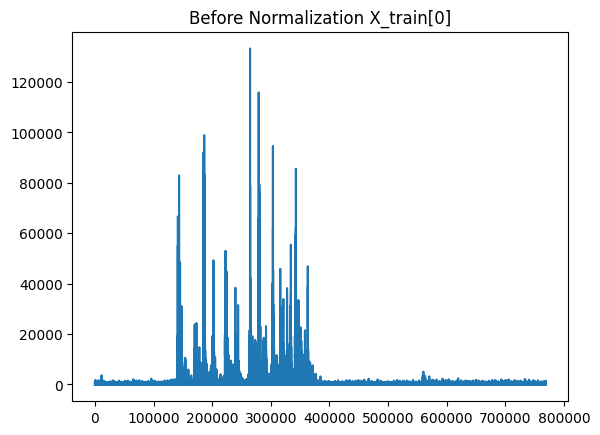

After normalization X_train[0]: [0. 0. 0. ... 0. 0. 0.]


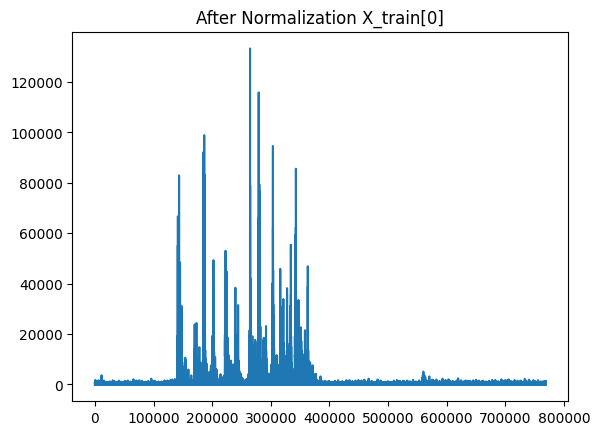

In [19]:
# Random State So it is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Graph before normalization
print(f'Before normalization X_train[0]: {X_train[0]}')
plt.figure()
plt.title("Before Normalization X_train[0]")
plt.plot(X_train[0])
plt.show()

# Scale and split data
sc = MinMaxScaler(feature_range=(0,1))

# Per sample scaling
#X_train = np.array([sc.fit_transform(sample.reshape(-1, 1)).flatten() for sample in X_train])
#X_test = np.array([sc.fit_transform(sample.reshape(-1, 1)).flatten() for sample in X_test])

# Graph after scaling
#print(f'After normalization X_train[0]: {X_train[0]}')
#plt.figure()
#plt.title("After Per Sample Normalization X_train[0]")
#plt.plot(X_train[0])
#plt.show()

# Global scaling
# sc.fit_transform on X_train and sc.transform on X_test to avoid data leakage
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Graph after scaling
print(f'After normalization X_train[0]: {X_train[0]}')
plt.figure()
plt.title("After Normalization X_train[0]")
plt.plot(X_train[0])
plt.show()

In [20]:
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')
print(f'X_test[0]: {X_test[0]}')
print(f'y_test[0]: {y_test[0]}')

train_coin_1 = 0
train_coin_2 = 0
train_coin_5 = 0
train_coin_20 = 0
train_coin_50 = 0
train_coin_100 = 0
train_coin_200 = 0

for i in range(y_train.shape[0]):
    if y_train[i] == 0:
        train_coin_1 += 1
    elif y_train[i] == 1:
        train_coin_2 += 1
    elif y_train[i] == 2:
        train_coin_5 += 1
    elif y_train[i] == 3:
        train_coin_20 += 1
    elif y_train[i] == 4:
        train_coin_50 += 1
    elif y_train[i] == 5:
        train_coin_100 += 1
    elif y_train[i] == 6:
        train_coin_200 += 1
        
print(f'coin 1: {train_coin_1}')
print(f'coin 2: {train_coin_2}')
print(f'coin 5: {train_coin_5}')
print(f'coin 20: {train_coin_20}')
print(f'coin 50: {train_coin_50}')
print(f'coin 100: {train_coin_100}')
print(f'coin 200: {train_coin_200}')

test_coin_1 = 0
test_coin_2 = 0
test_coin_5 = 0
test_coin_20 = 0
test_coin_50 = 0
test_coin_100 = 0
test_coin_200 = 0
for i in range(y_test.shape[0]):
    if y_test[i] == 0:
        test_coin_1 += 1
    elif y_test[i] == 1:
        test_coin_2 += 1
    elif y_test[i] == 2:
        test_coin_5 += 1
    elif y_test[i] == 3:
        test_coin_20 += 1
    elif y_test[i] == 4:
        test_coin_50 += 1
    elif y_test[i] == 5:
        test_coin_100 += 1
    elif y_test[i] == 6:
        test_coin_200 += 1
print(f'coin 1: {test_coin_1}')
print(f'coin 2: {test_coin_2}')
print(f'coin 5: {test_coin_5}')
print(f'coin 20: {test_coin_20}')
print(f'coin 50: {test_coin_50}')
print(f'coin 100: {test_coin_100}')
print(f'coin 200: {test_coin_200}')

X_train[0]: [0. 0. 0. ... 0. 0. 0.]
y_train[0]: 6.0
X_test[0]: [160.  96.   0. ... 288.  32. 192.]
y_test[0]: 4.0
coin 1: 118
coin 2: 138
coin 5: 104
coin 20: 112
coin 50: 100
coin 100: 146
coin 200: 157
coin 1: 33
coin 2: 32
coin 5: 26
coin 20: 25
coin 50: 30
coin 100: 34
coin 200: 39


In [21]:
# Creates TrainCoinDataSet
class TrainCoinDataSet(Dataset):

    def __init__(self, X_train, y_train):
        # Data Loading
        self.x = torch.from_numpy(X_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.n_samples = y_train.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples
    
class TestCoinDataSet(Dataset):

    def __init__(self, X_test, y_test):
        # Data Loading
        self.x = torch.from_numpy(X_test.astype(np.float32))
        self.y = torch.from_numpy(y_test).type(torch.LongTensor)
        self.n_samples = y_test.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples

In [22]:
# Creates Dataset
train_data = TrainCoinDataSet(X_train, y_train)
test_data = TestCoinDataSet(X_test, y_test)

875
219


In [23]:
print(train_data[0])
print(test_data[0])

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(6))
(tensor([160.,  96.,   0.,  ..., 288.,  32., 192.]), tensor(4))


In [24]:
# Defines Train and Test Datasets sizes
#train_size = int(0.8 * len(dataset))  # 80% of the data will be used for training
#test_size = len(dataset) - train_size  # Remaining 20% will be used for test

# Split dataset into training set and test set
#train_data, test_data = random_split(dataset, [train_size, test_size])

# Creates Dataloaders for train and test datasets
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)


In [25]:
print(f'Input shape: {samples.shape} , Labels shape: {labels.shape}')
print(f"Input range after standardization: Min = {samples[0].min()}, Max = {samples[0].max()}")
print(samples[0])
print(labels[0])
print(f'Input dtype: {samples[0,0].dtype}')
print(f'Label dtype: {labels[0].dtype}')
print(f'Labels: {labels}')

Input shape: torch.Size([8, 769024]) , Labels shape: torch.Size([8])
Input range after standardization: Min = 0.0, Max = 1023000.0
tensor([  0.,   0., 384.,  ...,   0.,   0.,   0.])
tensor(5)
Input dtype: torch.float32
Label dtype: torch.int64
Labels: tensor([5, 3, 4, 2, 2, 2, 1, 1])


In [26]:
# Create Model

# Model 
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # x -> (batch_size, seq, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Inside LSTM clas

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0,c0))

        # Dropout on output of LSTM
        out = self.dropout(out)

        # out: batch_size, seq_length, hidden_size
        # out (N, 6008, 128)
        # : all samples in batch, -1 last time step, : all features in hidden size

        out = out[:, -1, :] 
        
        # out (N, 128)
        out = self.fc(out)
        return out

In [27]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning Rate Scheduler (Reduce by factor of 0.1 every 10 epochs)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Reduces learning rate if loss plateaus
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [28]:
print(model)

LSTM(
  (lstm): LSTM(751, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [29]:
# Training loop

history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc': []}
all_preds = []
all_labels = []

train_loss_steps = []
train_acc_steps = []
running_loss_train_steps = 0.0
n_correct_train_steps = 0
n_samples_train_steps = 0

plot_steps, print_steps = 8,1

running_loss_train = 0.0
n_correct_train = 0
n_samples_train = 0

running_loss_val = 0.0
n_correct_val = 0
n_samples_val = 0

for epoch in range(num_epochs):
    
    model.train()
    running_loss_train = 0.0
    n_correct_train = 0
    n_samples_train = 0

    # Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # For Epoch Graph
        running_loss_train += loss.item()
        _, predictions = torch.max(outputs, 1)
        n_correct_train += (predictions == labels).sum().item()
        n_samples_train += labels.shape[0]

        # For Steps Graph
        running_loss_train_steps += loss.item()
        _, predictions = torch.max(outputs, 1)
        n_correct_train_steps += (predictions == labels).sum().item()
        n_samples_train_steps += labels.shape[0]
        
        if (i+1) % print_steps == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{len(train_loader)}, loss = {loss.item():.4f}')

        if (i+1) % plot_steps == 0:
            train_loss_steps.append(running_loss_train_steps / len(train_loader))
            train_acc_steps.append(100 * n_correct_train_steps / n_samples_train_steps)
            running_loss_train_steps = 0.0
            n_correct_train_steps = 0
            n_samples_train_steps = 0


    history['train_loss'].append(running_loss_train / len(train_loader))
    history['train_acc'].append(100 * n_correct_train / n_samples_train)

    # Test loop

    running_loss_val = 0.0
    n_correct_val = 0
    n_samples_val = 0

    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            running_loss_val += loss.item()
            _, predictions = torch.max(outputs, 1)
            n_correct_val += (predictions == labels).sum().item()
            n_samples_val += labels.shape[0]

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if (i+1) % print_steps == 0:
                print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{len(test_loader)}, loss = {loss.item():.4f}')

        history['val_loss'].append(running_loss_val / len(test_loader))
        history['val_acc'].append(100 * n_correct_val / n_samples_val)

epoch 1 / 500, step 1/110, loss = 1.9263
epoch 1 / 500, step 2/110, loss = 1.9357
epoch 1 / 500, step 3/110, loss = 1.9661
epoch 1 / 500, step 4/110, loss = 1.9459
epoch 1 / 500, step 5/110, loss = 1.9664
epoch 1 / 500, step 6/110, loss = 1.9285
epoch 1 / 500, step 7/110, loss = 1.9675
epoch 1 / 500, step 8/110, loss = 1.9530
epoch 1 / 500, step 9/110, loss = 1.9249
epoch 1 / 500, step 10/110, loss = 1.9602
epoch 1 / 500, step 11/110, loss = 1.9344
epoch 1 / 500, step 12/110, loss = 1.9479
epoch 1 / 500, step 13/110, loss = 1.9764
epoch 1 / 500, step 14/110, loss = 1.9845
epoch 1 / 500, step 15/110, loss = 1.9584
epoch 1 / 500, step 16/110, loss = 1.9525
epoch 1 / 500, step 17/110, loss = 1.9388
epoch 1 / 500, step 18/110, loss = 1.9744
epoch 1 / 500, step 19/110, loss = 1.9755
epoch 1 / 500, step 20/110, loss = 1.8809
epoch 1 / 500, step 21/110, loss = 1.9203
epoch 1 / 500, step 22/110, loss = 1.9338
epoch 1 / 500, step 23/110, loss = 1.9590
epoch 1 / 500, step 24/110, loss = 1.9470
e

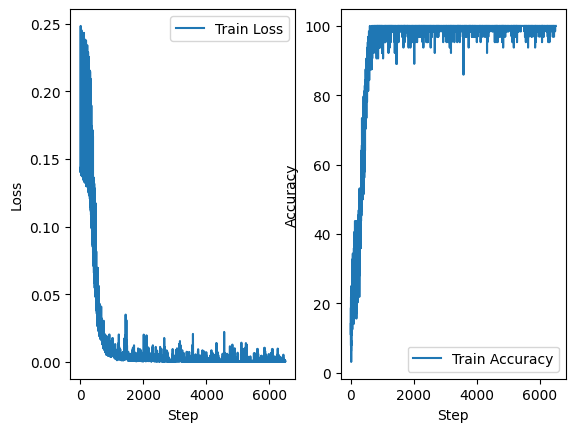

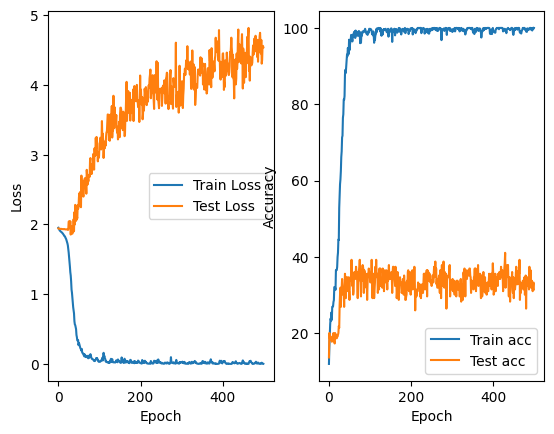

In [30]:
fig , ax = plt.subplots(1,2,sharex=True)

ax [0].plot(train_loss_steps, label='Train Loss')
ax [0].set_xlabel('Step')
ax [0].set_ylabel('Loss')
ax [0].legend()

ax [1].plot(train_acc_steps, label='Train Accuracy')
ax [1].set_xlabel('Step')
ax [1].set_ylabel('Accuracy')
ax [1].legend()

plt.savefig(results_dir + '/StepGraph.png')
plt.show() 

fig , ax = plt.subplots(1,2,sharex=True)

ax [0].plot(history['train_loss'], label='Train Loss')
ax [0].plot(history['val_loss'], label='Test Loss')
ax [0].set_xlabel('Epoch')
ax [0].set_ylabel('Loss')
ax [0].legend()

ax [1].plot(history['train_acc'], label='Train acc')
ax [1].plot(history['val_acc'], label='Test acc')
ax [1].set_xlabel('Epoch')
ax [1].set_ylabel('Accuracy')
ax [1].legend()

plt.savefig(results_dir + '/EpochGraph.png')
plt.show() 

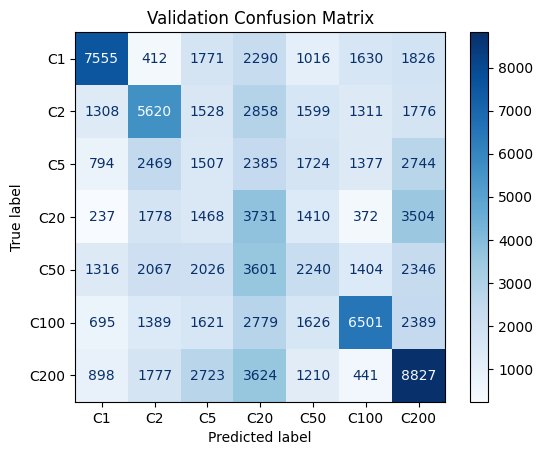

In [31]:
"""
Plot a confusion matrix using true and predicted labels.

Parameters:
    all_labels: List of true labels.
    all_preds: List of predicted labels.
    class_names: List of class names for labeling the confusion matrix.
"""
class_names = ['C1','C2','C5','C20','C50','C100','C200']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
disp.figure_.savefig(results_dir + 'Confusion_Matrix.png')
plt.show()


In [32]:
print(f"after {num_epochs} epochs the trainning accuracy is {history["train_acc"][-1]} and the test accuaracy is {history["val_acc"][-1]} ")

test_accuracy_max= max(history["val_acc"])
train_accuracy_max=max(history["train_acc"])

idx_max_test_accuracy=history["val_acc"].index(test_accuracy_max)

idx_max_train_accuracy=history["train_acc"].index(train_accuracy_max)

print(f" the maximum accuracy of the test was {max(history["val_acc"])} at the epoch {idx_max_test_accuracy}")

print(f" the maximum accuracy of the train was {max(history["train_acc"])} at the epoch {idx_max_train_accuracy}")

print(f"the accuracy of the training at the best validation accuracy {max(history["val_acc"])} is {history["train_acc"][idx_max_test_accuracy]}  ")

after 500 epochs the trainning accuracy is 100.0 and the test accuaracy is 31.506849315068493 
 the maximum accuracy of the test was 41.0958904109589 at the epoch 429
 the maximum accuracy of the train was 100.0 at the epoch 121
the accuracy of the training at the best validation accuracy 41.0958904109589 is 99.54285714285714  


In [33]:
print(model.state_dict())
torch.save(model.state_dict(), results_dir + "model_weights.pth")

# model.load_state_dict(torch.load(results_dir + "model_weights.pth"))


OrderedDict({'lstm.weight_ih_l0': tensor([[-0.0254, -0.0086, -0.0257,  ..., -0.0300, -0.0366,  0.0268],
        [ 0.0418,  0.0293, -0.0195,  ...,  0.0263, -0.0065, -0.0368],
        [-0.0279, -0.0266, -0.0283,  ..., -0.0080, -0.0348,  0.0091],
        ...,
        [-0.0077, -0.0415, -0.0023,  ..., -0.0283, -0.0099, -0.0293],
        [-0.0325, -0.0230, -0.0230,  ..., -0.0206,  0.0178, -0.0193],
        [ 0.0305, -0.0339,  0.0405,  ...,  0.0204,  0.0460,  0.0232]],
       device='cuda:0'), 'lstm.weight_hh_l0': tensor([[-0.0131, -0.0394, -0.0064,  ..., -0.0045, -0.0231,  0.0124],
        [-0.0095, -0.0214, -0.0008,  ..., -0.0336,  0.0333,  0.0289],
        [-0.0066,  0.0365, -0.0165,  ...,  0.0085,  0.0369, -0.0193],
        ...,
        [ 0.0248,  0.0398, -0.0257,  ..., -0.0278, -0.0450, -0.0130],
        [ 0.0241, -0.0332,  0.0375,  ..., -0.0139,  0.0329,  0.0010],
        [-0.0428, -0.0276,  0.0141,  ..., -0.0056,  0.0151,  0.0055]],
       device='cuda:0'), 'lstm.bias_ih_l0': tensor([

In [34]:
# Copy the 
shutil.copyfile('./lstm.ipynb', './' + results_dir + 'lstm_copy.ipynb')

'./David/Tests/18/lstm_copy.ipynb'